## Machine Learning
---
Pada proses pembuatan machine learning sebelumnya perlu dilakukan dulu `data cleaning`, `feature selection` dan `feature engineering`.
Pada Machine Learning yang dibuat ini menggunakan Regresi / Regression yang dimana pada hasil akhirnya akan menghasilkan prediksi harga yang akan ditampilkan dengan berbagai features akan akan di input oleh user.
Lalu pada proses pembuatan machine learning kali ini menggunakan metode **Pipeline**.

## Penggunaan Model
---
Untuk Model yang digunakan terdapat 5 model yaitu:

- Support Vector Regression (SVR)
- K-Nearest Neighbors Regression (KNN)
- Decision Tree Regression (DTree)
- Random Forest Regression (RF)
- XGBoost Regression (XGB)

Dari ke 5 model tersebut nantinya model base terbaik akan dilakukan Tuning sehingga akan menghasilkan nilai yang lebih baik dalam memprediksi hasil yang diinginkan.

## Data Understanding

- Dataset yang digunakan adalah [Belarus Used Cars Prices](https://www.kaggle.com/datasets/slavapasedko/belarus-used-cars-prices)
- Setiap baris dan kolom pada dataset ini memberikan informasi terkait mobil bekas yang dijual

**Attributes Information**

| **Attribute** | **Description** |
| --- | --- |
| make | Machine Firm |
| model | Model of car |
| priceUSD | Price in USD |
| year | Production Year |
| condition | Represents the condition at the sale moment |
| mileage(kilometers) | Mileage in kilometers |
| fuel_type | Type of the fuel (electro, petrol, diesel) |
| volume(cm3) | Volume of the engine |
| color | Color of Car |
| transmission | Transmission of Car |
| drive_unit | Type of drive unit |
| segment | segment (this feature was collected manually, so it could be wrong) |

<br>

## **Business Question For For Machine Learning**
- Bagaimana proyeksi dari model yang telah dibuat dan pengaruhnya terhadap perusahaan?
- Kapan machine learning akan digunakan?

In [1]:
# Import library yang dibutuhkan untuk eksplorasi dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce

from sklearn.model_selection import train_test_split, KFold, cross_val_score, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from sklearn.preprocessing import RobustScaler, PowerTransformer, PolynomialFeatures, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import TransformedTargetRegressor

from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load dataset
df = pd.read_csv('cars.csv')
df.head(10)

,make,model,priceUSD,year,condition,mileage(kilometers),fuel_type,volume(cm3),color,transmission,drive_unit,segment
0,mazda,2,5500,2008,with mileage,162000.0,petrol,1500.0,burgundy,mechanics,front-wheel drive,B
1,mazda,2,5350,2009,with mileage,120000.0,petrol,1300.0,black,mechanics,front-wheel drive,B
2,mazda,2,7000,2009,with mileage,61000.0,petrol,1500.0,silver,auto,front-wheel drive,B
3,mazda,2,3300,2003,with mileage,265000.0,diesel,1400.0,white,mechanics,front-wheel drive,B
4,mazda,2,5200,2008,with mileage,97183.0,diesel,1400.0,gray,mechanics,front-wheel drive,B
5,mazda,2,3400,2005,with mileage,150000.0,petrol,1300.0,blue,mechanics,front-wheel drive,B
6,mazda,2,5000,2008,with mileage,112000.0,petrol,1300.0,gray,mechanics,front-wheel drive,B
7,mazda,2,7300,2009,with mileage,95000.0,petrol,1500.0,other,auto,front-wheel drive,B
8,mazda,2,6400,2010,with mileage,93804.0,petrol,1500.0,other,mechanics,front-wheel drive,B
9,mazda,2,6132,2008,with mileage,196511.0,petrol,1500.0,other,auto,front-wheel drive,B


## Data Preprocessing

Pada tahap ini, kita akan melakukan cleaning data yang nantinya data yang sudah dibersihkan akan kita gunakan untuk proses analisis selanjutnya. Beberapa hal yang perlu dilakukan adalah:
- Drop fitur yang tidak memiliki relevansi terhadap permasalahan yang sedang dihadapi.
- Melakukan treatment terhadap missing value. Bisa dengan cara men-drop fiturnya jika memang tidak dibutuhkan atau bisa juga dengan mengimputasi dengan nilai yang paling masuk akal berdasarkan kasusnya.

Pada proses Data Pre Processing dan Feature Engineering akan menggunakan data duplikasi 

## Pembuatan tabel Deskripsi untuk Data understanding

In [3]:
dfDesc = []
for i in df.columns:
    dfDesc.append([i, 
                   df[i].dtypes, 
                   df[i].isna().sum(),
                   round(((df[i].isna().sum() / len(df)) * 100), 2),
                   df[i].nunique(),
                   df[i].drop_duplicates().sample(2).values
    ])
pd.DataFrame(
data=dfDesc,
columns = [
    'features',
    'DataType',
    'Null',
    'NullPercentage',
    'Unique',
    'Unique Sample'
])

,features,DataType,Null,NullPercentage,Unique,Unique Sample
0,make,object,0,0.00,96,"[geely, volkswagen]"
1,model,object,0,0.00,1034,"[tiburon, p601]"
2,priceUSD,int64,0,0.00,2970,"[63500, 3690]"
3,year,int64,0,0.00,78,"[2000, 1948]"
4,condition,object,0,0.00,3,"[with damage, for parts]"
5,mileage(kilometers),float64,0,0.00,8400,"[180367.0, 455444.0]"
6,fuel_type,object,0,0.00,3,"[diesel, electrocar]"
7,volume(cm3),float64,47,0.08,458,"[1461.0, 6200.0]"
8,color,object,0,0.00,13,"[silver, other]"
9,transmission,object,0,0.00,2,"[auto, mechanics]"


### Dapat dilihat info data yang sudah ditampilkan bahwa pada Dataset ini terdapat Missing Value pada:
- Features __volume(cm3)__, yang dimana pada features ini terdapat 47 baris missing value atau sekitar 0.08% dari total data
- Features __drive_unit__, yang dimana pada features ini terdapat 1905 baris missing value atau sekitar 3.39% dari total data
- Features __segment__, yang dimana pada features ini terdapat 5291 baris missing value atau sekitar 9.41% dari total data

Dalam mengatasi Missing Value pada dataset ini akan dilakukan:
- Pengecekan null pada features __volume(cm3)__ dilakukan agar dapat diketahui pada features __volume(cm3)__ keadaan mobil seperti apa yang memiliki kolom null
- Pengecekan null pada features __drive_unit__ dilakukan agar dapat diketahui pada features __volume(cm3)__ keadaan mobil seperti apa yang memiliki kolom null
- Menghilangkan features __segment__, karena pada deskripsi tentang features ini disebutkan bahwa *this feature was collected manually, so it could be wrong* yang artinya features segment dibuat dengan mengkoleksi data secara manual sehingga bisa jadi salah.

## Handling Missing Value

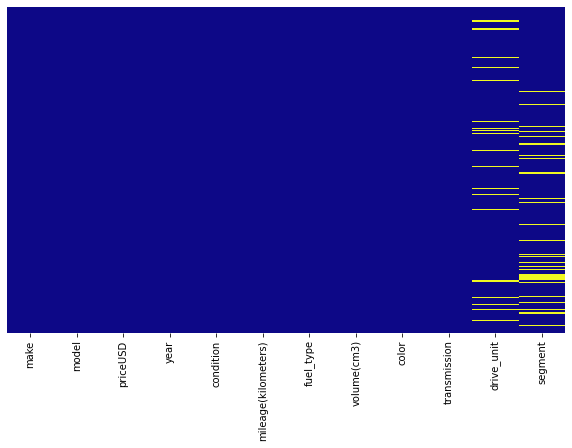

In [4]:
# Pengecekan Missing Value dengan Heatmap
plt.figure(figsize=(10,6))
sns.heatmap(df.isna(), cmap='plasma', cbar=False, yticklabels=False)
plt.show()

##### Melakukan cek missing value pada features volume(cm3)

In [5]:
df[df['volume(cm3)'].isna()]

,make,model,priceUSD,year,condition,mileage(kilometers),fuel_type,volume(cm3),color,transmission,drive_unit,segment
2268,alfa-romeo,147,8097,2007,with mileage,700.00,electrocar,NaN,burgundy,mechanics,NaN,C
4377,peugeot,406,5780,1995,with mileage,333333.00,electrocar,NaN,silver,auto,front-wheel drive,D
4865,fiat,500,14500,2014,with mileage,49000.00,electrocar,NaN,orange,auto,front-wheel drive,M
4867,fiat,500,13200,2013,with mileage,59900.00,electrocar,NaN,gray,auto,front-wheel drive,M
4868,fiat,500,14500,2015,with mileage,30000.00,electrocar,NaN,gray,auto,front-wheel drive,M
23577,cadillac,elr,25900,2014,with mileage,70000.00,electrocar,NaN,silver,auto,front-wheel drive,NaN
29346,bmw,i3,38000,2018,with mileage,67000.00,electrocar,NaN,other,auto,rear drive,NaN
29347,bmw,i3,57383,2017,with mileage,2822.00,electrocar,NaN,blue,auto,rear drive,NaN
29350,bmw,i3,22900,2014,with mileage,71500.00,electrocar,NaN,silver,auto,rear drive,NaN
29351,bmw,i3,22900,2015,with mileage,50000.00,electrocar,NaN,black,auto,rear drive,NaN


Insight : Setelah dilakukan pengecekan data, missing value yang terdapat pada features __volume(cm3)__ terdapat pada jenis mobil yang memiliki __fuel_type__ _electrocar_, sehingga untuk lebih pastinya kita akan melakukan pengecekan missing value pada features __fuel type__ dengan isi _electrocar_

In [6]:
df[df['fuel_type']=='electrocar'].isna().sum()

make                    0
model                   0
priceUSD                0
year                    0
condition               0
mileage(kilometers)     0
fuel_type               0
volume(cm3)            47
color                   0
transmission            0
drive_unit              2
segment                40
dtype: int64

In [7]:
df.describe().round()

,priceUSD,year,mileage(kilometers),volume(cm3)
count,56244.0,56244.0,56244.0,56197.0
mean,7415.0,2003.0,244396.0,2105.0
std,8317.0,8.0,321031.0,959.0
min,48.0,1910.0,0.0,500.0
25%,2350.0,1998.0,137000.0,1600.0
50%,5350.0,2004.0,228500.0,1996.0
75%,9808.0,2010.0,310000.0,2300.0
max,235235.0,2019.0,9999999.0,20000.0


Insight : Setelah dilakukan pengecekan jumlah missing value pada _electrocar_ ternyata jumlah null yang ada sesuai dengan jumlah missing value yang ada pada features __volume(cm3)__

- Tindakan yang akan dilakukan adalah pada Project kali ini kita akan melakukan Project Limitation yang dimana pada Project kali ini kita tidak akan memakai baris data mobil dengan __fuel_type__ _electrocar_

In [8]:
df = df[df['fuel_type']!='electrocar']

In [9]:
df.isna().sum()

make                      0
model                     0
priceUSD                  0
year                      0
condition                 0
mileage(kilometers)       0
fuel_type                 0
volume(cm3)               0
color                     0
transmission              0
drive_unit             1903
segment                5251
dtype: int64

Setelah kita menghilangkan missing value pada features volume(cm3), maka selanjutnya kita akan menghandle missing value pada features lainnya

##### Menganalisa Missing Value pada Features drive_unit

In [10]:
df['drive_unit'].isna().sum()

1903

Karena jumlah null yang ada pada features ini terbilang banyak, maka pada project ini kita mengisi missing value dengan modus dari unique yang terdapat pada features drive_unit

In [11]:
# Mencari Modus untuk features drive_unit
df['drive_unit'].mode().values

array(['front-wheel drive'], dtype=object)

Insight : Modus terbanyak adalah `front-wheel drive` untuk features drive_unit, jadi Missing Value pada features drive_unit akan diisi oleh front-wheel drive

In [12]:
df['drive_unit'] = df['drive_unit'].fillna('front-wheel drive')

In [13]:
df['drive_unit'].isna().sum()

0

##### Menghandle Missing Value features segment dengan mendrop Kolom segment, karena seperti yang sudah disebutkan pada deskripsi sebelumnya bahwa kolom segment mengkoleksi data secara manual sehingga bisa jadi salah

In [14]:
df.drop(columns='segment', axis=1, inplace=True)

In [15]:
df.head()

,make,model,priceUSD,year,condition,mileage(kilometers),fuel_type,volume(cm3),color,transmission,drive_unit
0,mazda,2,5500,2008,with mileage,162000.0,petrol,1500.0,burgundy,mechanics,front-wheel drive
1,mazda,2,5350,2009,with mileage,120000.0,petrol,1300.0,black,mechanics,front-wheel drive
2,mazda,2,7000,2009,with mileage,61000.0,petrol,1500.0,silver,auto,front-wheel drive
3,mazda,2,3300,2003,with mileage,265000.0,diesel,1400.0,white,mechanics,front-wheel drive
4,mazda,2,5200,2008,with mileage,97183.0,diesel,1400.0,gray,mechanics,front-wheel drive


### Feature Selection

#### Membuang unique "For Parts" pada Features condition

In [16]:
df = df[df['condition']!='for parts']

#### Outliers Detection

Outliers adalah data yang menyimpang terlalu jauh dari data yang lainnya dalam suatu rangkaian data (pencilan). Adanya data outliers ini akan membuat analisis terhadap serangkaian data menjadi bias, atau tidak mencerminkan fenomena yang sebenarnya. Ada beberapa hal yang harus dipertimbangkan sebelum memutuskan treatment yang sesuai dengan data, di antaranya adalah dengan mempertimbangkan sisi domain knowledge.

In [17]:
df.describe().round()

,priceUSD,year,mileage(kilometers),volume(cm3)
count,55743.0,55743.0,55743.0,55743.0
mean,7446.0,2004.0,243483.0,2107.0
std,8224.0,8.0,310793.0,957.0
min,48.0,1910.0,0.0,500.0
25%,2422.0,1998.0,137000.0,1600.0
50%,5400.0,2004.0,228000.0,1998.0
75%,9900.0,2010.0,310000.0,2300.0
max,235235.0,2019.0,9999999.0,20000.0


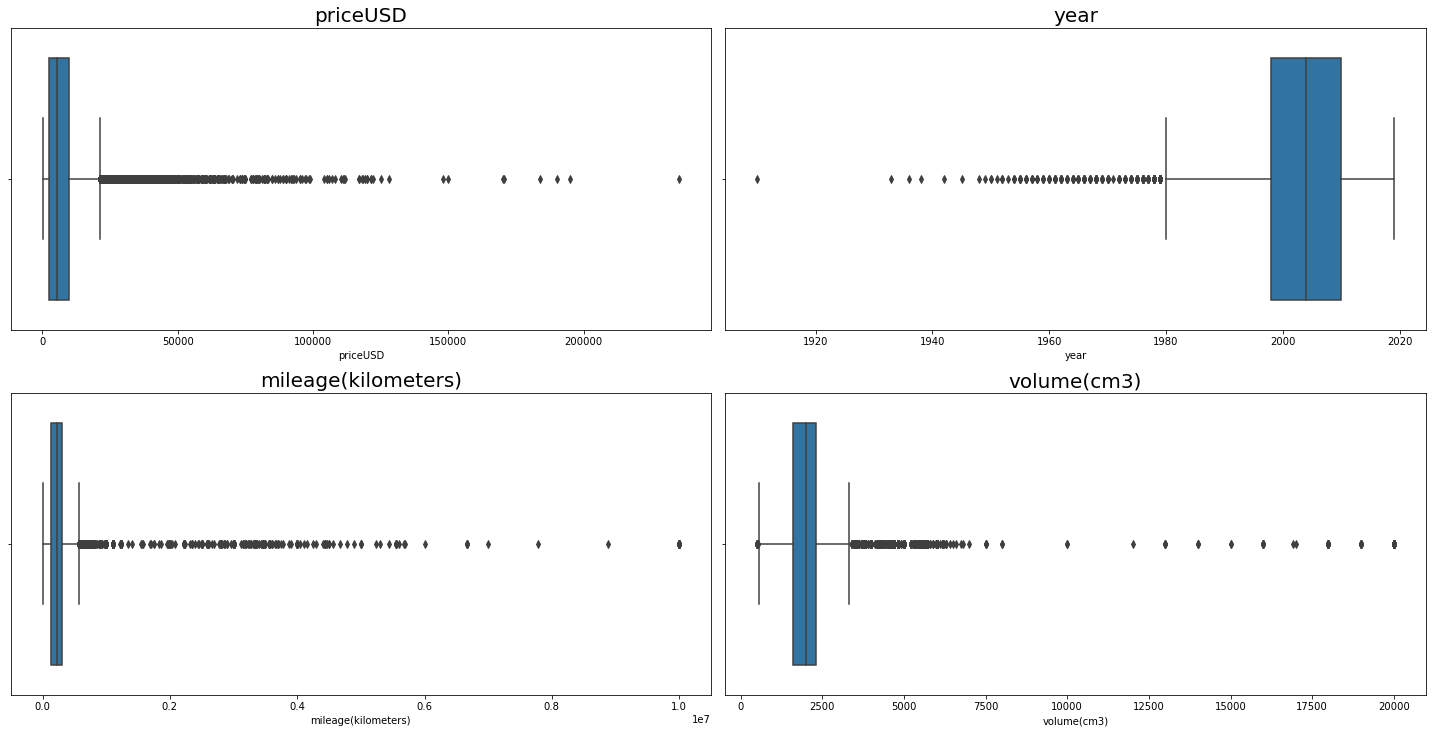

In [18]:
count = 0
fig = plt.figure(figsize=(20,20))

for i in df.drop(columns=['make','model','condition','fuel_type','color','transmission','drive_unit']).columns:
    count +=1
    ax= plt.subplot(4,2,count)
    sns.boxplot(df[i])
    fig.tight_layout()
    plt.title(i,fontsize=20)

plt.show()

Terlihat pada fitur-fitur numerikal terdapat outliers. Namun yang akan kita fokuskan pada fitur year dan priceUSD karena pada project ini hanya akan menggunakan data mengenai mobil diatas tahun 1980 dan harga mobil kurang dari sama dengan nilai median yang mana 5.400 USD karena itu adalah nilai central of Tendency, maka perlu melakukan rekayasa data pada fitur `year` dan `priceUSD`. Pada boxplot `year` dan `priceUSD` diatas menunjukan pada fitur year terdapat skewness pada distribusinya, yaitu tail yang memanjang di sebelah kiri (negative skewness), sedangkan fitur priceUSD terdapat skewness pada distribusinya, yaitu tail yang memanjang di sebelah kanan (positive skewness)

In [19]:
def find_anomalies(data):
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr = q3 - q1
    limit = iqr*1.5
    print(f'IQR: {iqr}')

    limit_bawah = q1 - limit
    limit_atas = q3 + limit
    print(f'limit_bawah: {limit_bawah}')
    print(f'limit_atas: {limit_atas}')

In [20]:
for i in df.drop(columns=['make','model','condition','fuel_type','color','transmission','drive_unit']).columns:
    print(i)
    df_anomalies = find_anomalies(df[i])
    print(20*('='))

priceUSD
IQR: 7478.0
limit_bawah: -8795.0
limit_atas: 21117.0
year
IQR: 12.0
limit_bawah: 1980.0
limit_atas: 2028.0
mileage(kilometers)
IQR: 173000.0
limit_bawah: -122500.0
limit_atas: 569500.0
volume(cm3)
IQR: 700.0
limit_bawah: 550.0
limit_atas: 3350.0


In [21]:
# Melakukan filtering pada data
df = df[df['year'] >= 1980]
df = df[df['priceUSD'] <= 5400]

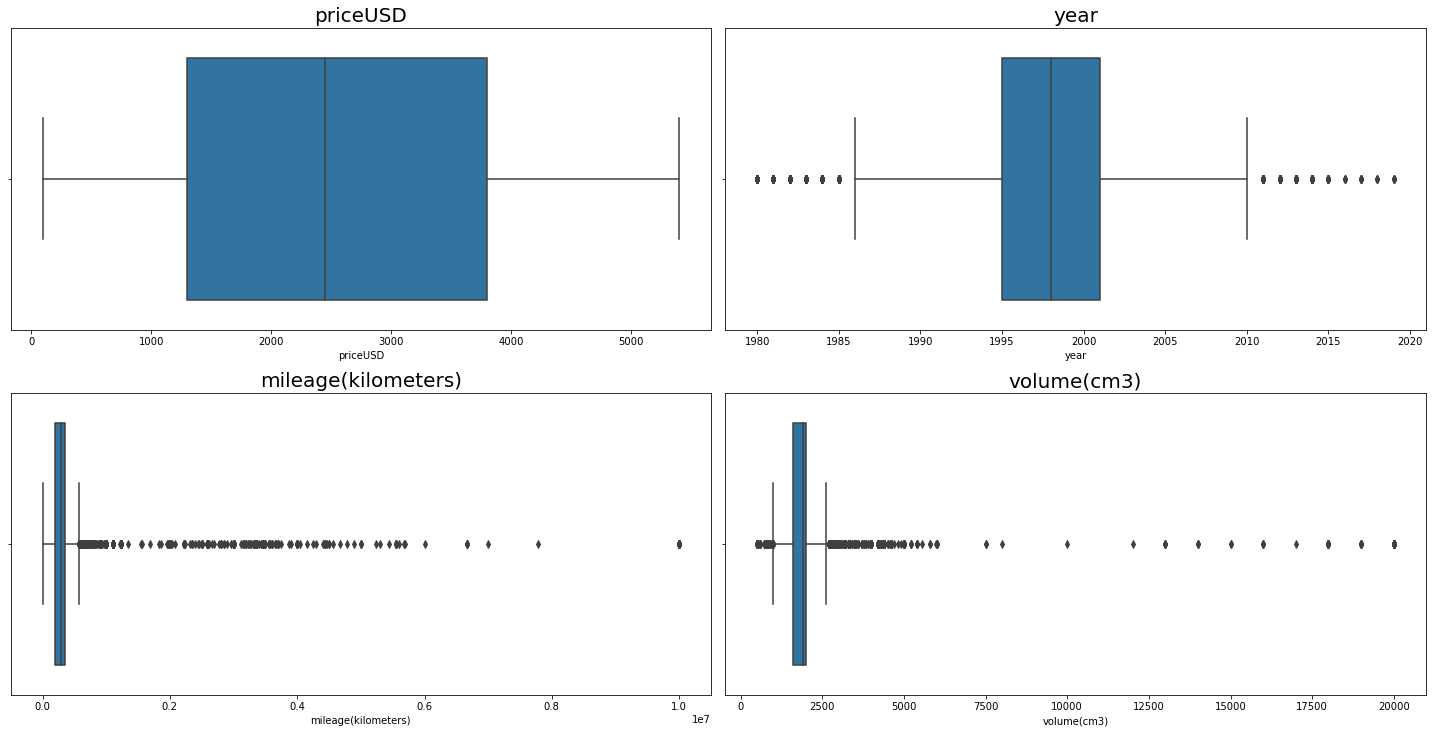

In [22]:
count = 0
fig = plt.figure(figsize=(20,20))

for i in df.drop(columns=['make','model','condition','fuel_type','color','transmission','drive_unit']).columns:
    count +=1
    ax= plt.subplot(4,2,count)
    sns.boxplot(df[i])
    fig.tight_layout()
    plt.title(i,fontsize=20)

plt.show()

### Data Corelation 

In [23]:
import dython
from dython.nominal import associations, cramers_v, theils_u, correlation_ratio

Cek korelasi akan dibagi menjadi 2 bagian untuk fitur numerikal dan fitur kategorikal.

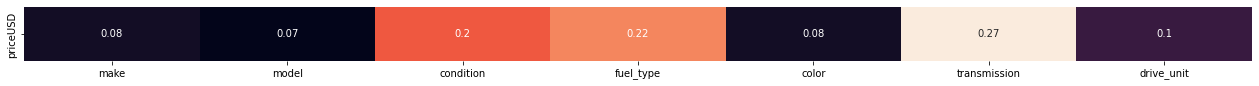

In [24]:
assoc_cr = []
col = ['make','model','condition','fuel_type','color','transmission','drive_unit']
for i in col: 
    assoc = round(cramers_v(df['priceUSD'], df[i]), 2) 
    assoc_cr.append(assoc)
    
df_cr = pd.DataFrame(data = [assoc_cr], columns = col, index=['priceUSD'])

plt.figure(figsize=(22, 1))
sns.heatmap(df_cr, annot = True, cbar=False)
plt.show()

Pada fitur kategorikal untuk melakukan cek korelasi tanpa perlu merubah tipe data, kita menggunakan association corelation, dimana dari pengecekan tersebut tidak terlihat fitur yang menunjukan korelasi tinggi dan semuanya korelasi positif terhadap fitur priceUSD. 

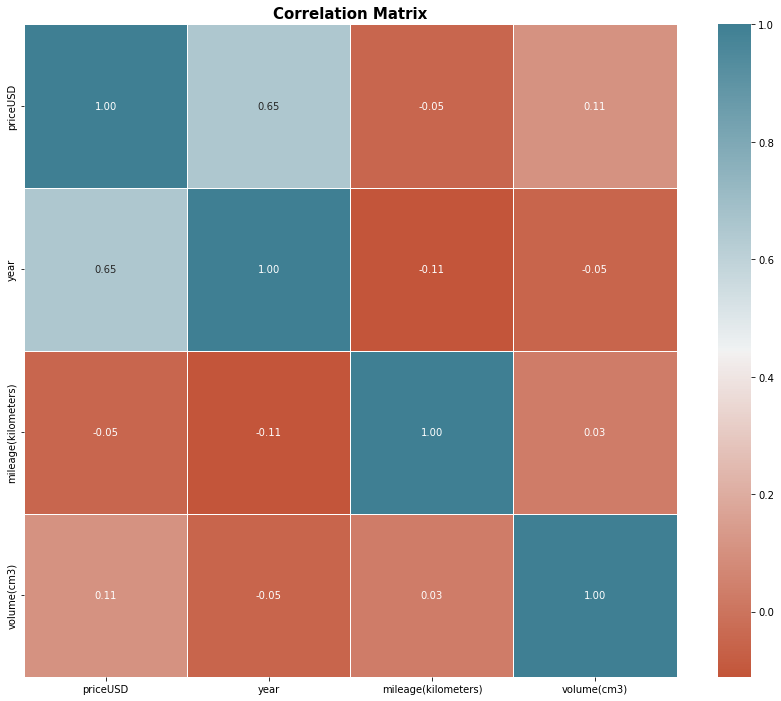

In [25]:
# Correlation matrix
plt.figure(figsize=(15, 12))
palette=sns.diverging_palette(20, 220, n=256)
corr = df.corr(method='pearson')
sns.heatmap(corr, annot=True, fmt='.2f', cmap=palette, square=True, linewidths=.5)
plt.title('Correlation Matrix', size=15, weight='bold');

Untuk fitur numerikal kita melakukan pengecekan korelasi dengan menggunakan pearson correlation dikarenakankita ingin melihat linear correlation dimana pearson correlation sangat cocok digunakan untuk mencari hubungan linear correlation.
Dari hasil pengecekan korelasi menunjukan tidak ada fitur yang korelasi tinggi, tetapi dapat dilihat bahwa ada beberapa fitur yang memiliki korelasi positif dan negaitf, yaitu :

Korelasi Positif (+) :
- year
- volume(cm3)          

Korelasi Negatif (-)
- mileage(kilometers)

## Cek Duplikasi pada Data

Langkah selanjutnya yaitu kami akan melakukan pengecekan terhadap duplikasi data

In [26]:
df[df.duplicated()]

,make,model,priceUSD,year,condition,mileage(kilometers),fuel_type,volume(cm3),color,transmission,drive_unit
832,renault,19,700,1993,with mileage,300000.0,petrol,1800.0,burgundy,mechanics,front-wheel drive
1930,audi,100,1280,1991,with mileage,305000.0,petrol,2300.0,red,mechanics,front-wheel drive
2054,audi,100,2000,1988,with mileage,350000.0,petrol,2300.0,blue,mechanics,front-wheel drive
2140,audi,100,1100,1989,with mileage,350000.0,petrol,2300.0,burgundy,mechanics,front-wheel drive
2179,peugeot,106,700,2000,with mileage,27000.0,diesel,1500.0,blue,mechanics,front-wheel drive
4334,peugeot,406,2200,1995,with mileage,330000.0,petrol,1800.0,gray,mechanics,front-wheel drive
4411,peugeot,406,3800,1999,with mileage,580000.0,petrol,2000.0,silver,mechanics,front-wheel drive
4456,peugeot,406,1300,1995,with mileage,390000.0,petrol,1800.0,green,mechanics,front-wheel drive
4529,peugeot,407,4350,2005,with mileage,311021.0,diesel,1600.0,white,mechanics,front-wheel drive
4817,volvo,460,1000,1996,with mileage,360000.0,petrol,1800.0,silver,mechanics,front-wheel drive


In [27]:
df[df.duplicated()].count()

make                   54
model                  54
priceUSD               54
year                   54
condition              54
mileage(kilometers)    54
fuel_type              54
volume(cm3)            54
color                  54
transmission           54
drive_unit             54
dtype: int64

Dari data yang ditemukan, terdapat 54 duplikasi data, maka dari itu kami akan melakukan *filtering* atau menghilangkan duplikasi data yang ada

In [28]:
## Menghapus Duplikat
df.drop_duplicates(inplace = True)

Setelah dihapus maka kami melakukan pengecekan kembali.

In [29]:
## Check Ulang Data Duplikat
df[df.duplicated()].count()

make                   0
model                  0
priceUSD               0
year                   0
condition              0
mileage(kilometers)    0
fuel_type              0
volume(cm3)            0
color                  0
transmission           0
drive_unit             0
dtype: int64

# Modeliing

### Encoding

Agar dapat menggunakan semua fitur yang dipilih, maka fitur-fitur kategorikal harus diubah menjadi fitur numerikal. Kita dapat menggunakan ColumnTransformer untuk dapat mengubah tipe datanya, yang mana nanti dapat diaplikasikan pada pipeline model.

In [30]:
# Mengubah fitur kategorikal menjadi numerikal
transformer = ColumnTransformer([
    ('One Hot', OneHotEncoder(drop='first'), ['condition', 'fuel_type', 'transmission', 'drive_unit', 'color']),
    ('Binary', ce.BinaryEncoder(), ['make', 'model'])
], remainder='passthrough')

### Splitting Data

In [31]:
# Membuat Sub-Data untuk melakukan Train dan Test
df_1 = df

In [32]:
# Memisahkan data independen variabel dengan target
X = df_1.drop(columns=['priceUSD'])
y = df_1['priceUSD']

In [33]:
# Splitting data training dan test dengan proporsi 80:20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =.20, random_state=42)

### Mengecek kestabilan Data dan Model

In [34]:
crossval = KFold(n_splits=5, shuffle=True, random_state=1)

In [35]:
# Define algoritma yang digunakan
svr = SVR()
knn = KNeighborsRegressor()
dt = DecisionTreeRegressor(random_state=1)
rf = RandomForestRegressor(random_state=1)
xgb = XGBRegressor(random_state=1)

# Pemodelan dilakukan dalam skala logaritmik, namun kemudian di-inverse kembali untuk interpretasi
log_svr = TransformedTargetRegressor(svr, func=np.log, inverse_func=np.exp)
log_knn = TransformedTargetRegressor(knn, func=np.log, inverse_func=np.exp)
log_dt = TransformedTargetRegressor(dt, func=np.log, inverse_func=np.exp)
log_rf = TransformedTargetRegressor(rf, func=np.log, inverse_func=np.exp)
log_xgb = TransformedTargetRegressor(xgb, func=np.log, inverse_func=np.exp)

# Scaling data
scaler = RobustScaler()

# Kandidat algoritma
models = [log_svr, log_knn, log_dt, log_rf, log_xgb]

score_r2 = []
nilai_mean_r2 = []
nilai_std_r2 = []

score_mae = []
nilai_mean_mae = []
nilai_std_mae = []

score_mse = []
nilai_mean_mse = []
nilai_std_mse = []

score_rmse = []
nilai_mean_rmse = []
nilai_std_rmse = []

# Mencari algoritma terbaik berdasarkan nilai MAE
for i in models:
    
    crossval = KFold(n_splits=5, shuffle=True, random_state=1)

    estimator = Pipeline([
        ('preprocessing', transformer),
        ('scaler', scaler),
        ('model', i)
    ])
    
    # R2
    model_cv_r2 = cross_val_score(
        estimator, 
        X_train, 
        y_train, 
        cv=crossval, 
        scoring='r2', 
        error_score='raise'
        )

    print(model_cv_r2, i)

    score_r2.append(model_cv_r2)
    nilai_mean_r2.append(model_cv_r2.mean())
    nilai_std_r2.append(model_cv_r2.std())


    # MAE
    model_cv_mae = cross_val_score(
        estimator, 
        X_train, 
        y_train, 
        cv=crossval, 
        scoring='neg_mean_absolute_error', 
        error_score='raise'
        )

    print(model_cv_mae, i)

    score_mae.append(model_cv_mae)
    nilai_mean_mae.append(model_cv_mae.mean())
    nilai_std_mae.append(model_cv_mae.std())

    # MSE
    model_cv_mse = cross_val_score(
        estimator, 
        X_train, 
        y_train, 
        cv=crossval, 
        scoring='neg_mean_squared_error', 
        error_score='raise'
        )

    print(model_cv_mse, i)

    score_mse.append(model_cv_mse)
    nilai_mean_mse.append(model_cv_mse.mean())
    nilai_std_mse.append(model_cv_mse.std())

    # RMSE
    model_cv_rmse = cross_val_score(
        estimator, 
        X_train, 
        y_train, 
        cv=crossval, 
        scoring='neg_root_mean_squared_error', 
        error_score='raise'
        )

    print(model_cv_rmse, i)

    score_rmse.append(model_cv_rmse)
    nilai_mean_rmse.append(model_cv_rmse.mean())
    nilai_std_rmse.append(model_cv_rmse.std())

[0.76352688 0.78712974 0.77398549 0.77185114 0.76007187] TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=SVR())
[-524.3721322  -507.19669362 -520.23106134 -518.32380985 -527.47711526] TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=SVR())
[-491310.89597915 -452334.68904332 -473535.4769349  -475126.94394136
 -498499.67697635] TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=SVR())
[-700.93572885 -672.55831646 -688.13914068 -689.29452627 -706.04509557] TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=SVR())
[0.71483528 0.72479671 0.72645718 0.72629427 0.70811744] TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=KNeighborsRegressor())
[-580.88236769 -576.08301504 -576.02592133 

In [36]:
# Evaluasi hasil dari 5 kandidat algoritma yang digunakan
pd.DataFrame({
    'Model': ['Support Vector Regression', 'KNN Regressor', 'DecisionTree Regressor', 'RandomForest Regressor', 'XGBoost Regressor'],
    'Mean_R2': nilai_mean_r2,
    'Std_R2': nilai_std_r2,
    'Mean_MAE': nilai_mean_mae,
    'Std_MAE': nilai_std_mae,
    'Mean_MSE': nilai_mean_mse,
    'Std_MSE': nilai_std_mse,
    'Mean_RMSE': nilai_mean_rmse,
    'Std_RMSE': nilai_std_rmse,
})

,Model,Mean_R2,Std_R2,Mean_MAE,Std_MAE,Mean_MSE,Std_MSE,Mean_RMSE,Std_RMSE
0,Support Vector Regression,0.771313,0.009430,-519.520162,6.937712,-478161.536575,16026.108956,-691.394562,11.623115
1,KNN Regressor,0.720100,0.007378,-579.170170,4.340588,-585364.876036,13277.220441,-765.042404,8.660044
2,DecisionTree Regressor,0.616833,0.020262,-664.838397,15.180515,-801393.311215,42027.581493,-894.897743,23.480634
3,RandomForest Regressor,0.785599,0.008458,-505.315724,5.770494,-448323.142608,14961.309490,-669.476659,11.142091
4,XGBoost Regressor,0.776949,0.007282,-515.080873,4.038009,-466403.971455,11400.981312,-682.886153,8.394831


**Insight** :
- Sesuai Cross Validation Score nilai rata-rata RMSE, XGBoost adalah model terbaik. Sedangkan jika berdasarkan nilai rata-rata MAE, RandomForest memiliki nilai paling rendah.
- Selanjutnya, akan dilakukan prediksi pada test set dengan semua benchmark model

### Evaluation Matrix Score Model

In [37]:
pd.options.display.float_format = '{:.2f}'.format

In [38]:
def Eva_Matrix_DF(Model,X_train, X_test, y_train, y_test, Nama):
    y_pred_tr = Model.predict(X_train)
    R2_tr = r2_score(y_train, y_pred_tr)
    MAE_tr = mean_absolute_error(y_train, y_pred_tr)
    MSE_tr = mean_squared_error(y_train, y_pred_tr)
    RMSE_tr = np.sqrt(MSE_tr)
    y_pred_ts = Model.predict(X_test)
    R2_ts = r2_score(y_test, y_pred_ts)
    MAE_ts = mean_absolute_error(y_test, y_pred_ts)
    MSE_ts = mean_squared_error(y_test, y_pred_ts)
    RMSE_ts = np.sqrt(MSE_ts)
    data = {
        'Training' + Nama : [R2_tr, MAE_tr, MSE_tr, RMSE_tr],
        'Testing' + Nama : [R2_ts, MAE_ts, MSE_ts, RMSE_ts]}
    df = pd.DataFrame(data=data, index = ['R2', 'MAE', 'MSE', 'RMSE'])
    return df

### Membuat Pipeline Model

In [39]:
# Memasukan Column Numerikal
num_columns = ['year', 'mileage(kilometers)', 'volume(cm3)']

# Memasukan Scaller, Polynomial dan Power Transformer
numeric_pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('poly', PolynomialFeatures(degree=3, include_bias=False)),
    ('power', PowerTransformer(method='yeo-johnson'))
])

# Memasukan Encoding dengan Binary Encoder
categoric_pipeline = Pipeline([
    ('encoder', ce.BinaryEncoder())
])

# 5 Model Pipeline yang digunakan
pipe_SVR = Pipeline([
    ('preprocessing', transformer),
    ('algo', SVR())
])

pipe_KNN = Pipeline([
    ('preprocessing', transformer),
    ('algo', KNeighborsRegressor())
])

pipe_DTree = Pipeline([
    ('preprocessing', transformer),
    ('algo', DecisionTreeRegressor())
])

pipe_RF = Pipeline([
    ('preprocessing', transformer),
    ('algo', RandomForestRegressor())
])

pipe_XGB = Pipeline([
    ('preprocessing', transformer),
    ('algo', XGBRegressor())
])

In [40]:
# Mentraining Data
dfbase = [pipe_SVR, pipe_KNN, pipe_DTree, pipe_RF, pipe_XGB]

for i in dfbase:
    i.fit(X_train, y_train)

In [41]:
# Evaluasion Matrix
df_SVR_base = Eva_Matrix_DF(pipe_SVR, X_train, X_test, y_train, y_test, 'Base SVR')
df_KNN_base = Eva_Matrix_DF(pipe_KNN, X_train, X_test, y_train, y_test, 'Base KNN')
df_DTree_base = Eva_Matrix_DF(pipe_DTree, X_train, X_test, y_train, y_test, 'Base DTree')
df_RF_base = Eva_Matrix_DF(pipe_RF, X_train, X_test, y_train, y_test, 'Base RF')
df_XGB_base = Eva_Matrix_DF(pipe_XGB, X_train, X_test, y_train, y_test, 'Base XGB')

In [42]:
# Menampilkan Hasil Evaluasi Matrix
df_all = pd.concat([df_SVR_base, df_KNN_base, df_DTree_base, df_RF_base, df_XGB_base], axis=1)
df_all

,TrainingBase SVR,TestingBase SVR,TrainingBase KNN,TestingBase KNN,TrainingBase DTree,TestingBase DTree,TrainingBase RF,TestingBase RF,TrainingBase XGB,TestingBase XGB
R2,0.00,0.00,0.55,0.31,1.00,0.62,0.97,0.80,0.87,0.80
MAE,1241.05,1238.22,763.72,945.57,4.67,655.04,187.25,490.60,399.19,489.55
MSE,2088872.56,2072013.73,947202.18,1432897.87,1969.79,789585.70,61789.11,425195.86,269625.50,412853.77
RMSE,1445.29,1439.45,973.24,1197.04,44.38,888.59,248.57,652.07,519.25,642.54


Insight : 
Berdasarkan dari hasil yang sudah didapatkan, pada Project kali ini kita akan Fokus untuk melihat pada nilai Testing RMSE Terendah, yang dimana pada hasil yang didapatkan nilai RMSE Testing Terendah ada pada model XGB dengan nilai error 642, maka pada Proses selanjutnya kita akan melakukan Improvement Model / Tuning dengan menggunakan Model XGB dengan harapan nilai RMSE yang didapatkan nantinya akan semakin kecil

# Improvement

### XG Boost Hyper Parameter Tuning

In [43]:
# Menampilkan parameter apa saja yang dapat digunakan
pipe_XGB.get_params()

{'memory': None,
 'steps': [('preprocessing',
   ColumnTransformer(remainder='passthrough',
                     transformers=[('One Hot', OneHotEncoder(drop='first'),
                                    ['condition', 'fuel_type', 'transmission',
                                     'drive_unit', 'color']),
                                   ('Binary', BinaryEncoder(), ['make', 'model'])])),
  ('algo',
   XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
                colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
                early_stopping_rounds=None, enable_categorical=False,
                eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
                importance_type=None, interaction_constraints='',
                learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
                max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
                missing=nan, monotone_constraints='()', n_estimators=100, n_jo

In [44]:
# Kedalaman pohon
max_depth = np.arange(1, 11)

# Learning rate
learning_rate = np.arange(0, 1, 0.1)

# Jumlah pohon
n_estimators = np.arange(100, 201, 10)

# Jumlah baris tiap pohon (% dari total baris train set)
subsample = np.arange(0, 1, 0.1)

# Jumlah feature yang digunakan untuk tiap pohon (% dari total kolom train set)
colsample_bytree = np.arange(0, 1, 0.1)

# Alpha (regularization)
reg_alpha = np.logspace(-3, 3, 7) # Semakin besar nilainya, semakin konservatif/simpel modelnya


# Hyperparam space XGboost
param_XGB = {
    'algo__max_depth': max_depth, 
    'algo__learning_rate': learning_rate,
    'algo__n_estimators': n_estimators,
    'algo__subsample': subsample,
    'algo__colsample_bytree': colsample_bytree,
    'algo__reg_alpha': reg_alpha
}

In [45]:
RS_XGB = RandomizedSearchCV(pipe_XGB, param_XGB, cv = 4, n_jobs=-1, verbose=1, scoring ='neg_root_mean_squared_error',n_iter=1000)

Disini kami menggunakan Randomized Search untuk melakukan Tuning Model terbaik, karena jika menggunakan Grid Search akan melakukan validasi satu-satu yang mana akan memakan waktu yang sangat lama ketika melakukan tuning, jadi dengan menggunakan Randomized Search mesin akan mencari algoritma secara acak sesuai dengan iterasi yang telah kita input, dalam kasus ini iterasi yang digunakan sebanyak 1000 dengan cv = 4, maka ada total 4000 kemungkinan

In [46]:
# Mentraining Data Tuning
RS_XGB.fit(X_train, y_train)

Fitting 4 folds for each of 1000 candidates, totalling 4000 fits


RandomizedSearchCV(cv=4,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('One '
                                                                               'Hot',
                                                                               OneHotEncoder(drop='first'),
                                                                               ['condition',
                                                                                'fuel_type',
                                                                                'transmission',
                                                                                'drive_unit',
                                                                                'color']),
                                                                            

In [47]:
# Memilih Estimator terbaik
XGB_Tuned = RS_XGB.best_estimator_

In [48]:
# Menampilkan Eva Matrix Score setelah dilakukan Tuning
df_XGB = Eva_Matrix_DF(XGB_Tuned, X_train, X_test, y_train, y_test, 'XG Boost Tuned')
df_XGB

,TrainingXG Boost Tuned,TestingXG Boost Tuned
R2,0.90,0.81
MAE,357.74,474.28
MSE,217876.08,386854.42
RMSE,466.77,621.98


### Hasil Akhir

In [49]:
# Menampilkan hasil Evaluation Matrix dengan menggabungkan 2 model terbaik sebelum data sesudah di Tunning
df_tuned = pd.concat([df_XGB_base, df_XGB], axis=1)
df_tuned

,TrainingBase XGB,TestingBase XGB,TrainingXG Boost Tuned,TestingXG Boost Tuned
R2,0.87,0.80,0.90,0.81
MAE,399.19,489.55,357.74,474.28
MSE,269625.50,412853.77,217876.08,386854.42
RMSE,519.25,642.54,466.77,621.98


Dapat dilihat bahwa dari Model yang sudah di Tunning terdapat perbedaan Nilai pada RMSE yang awalnya 642 turun menjadi 616.86

### Analisis Error untuk model terbaik

In [50]:
y_pred=XGB_Tuned.predict(X_test)

In [51]:
# Pengecekan Nilai Error
error = abs(y_pred-y_test)
pd.DataFrame(error).head()

,priceUSD
54154,468.80
16406,721.66
50951,116.63
46843,466.63
16371,557.51


In [52]:
# Membuat Kolom baru untuk menampilkan Harga Price aktual
X_test['actual'] = y_test

In [53]:
# Membuat Kolom baru untuk menampilkan Harga Price prediksi
X_test['prediksi'] = y_pred

In [54]:
# Membuat Kolom baru untuk menampilkan Error antara Harga Price aktual dengan prediksi
X_test['error'] = error

In [55]:
X_test.sort_values('error', ascending=False).head(10)

,make,model,year,condition,mileage(kilometers),fuel_type,volume(cm3),color,transmission,drive_unit,actual,prediksi,error
995,uaz,31,1990,with mileage,20000.00,petrol,2400.00,green,mechanics,part-time four-wheel drive,5300,1134.86,4165.14
6673,moskvich,2140,1981,with mileage,90000.00,petrol,1500.00,blue,mechanics,rear drive,4000,792.61,3207.39
32655,subaru,libero,1996,with mileage,185000.00,petrol,1200.00,red,mechanics,part-time four-wheel drive,4999,1824.50,3174.50
44735,eksklyuziv,samodelnyj,2015,with mileage,300.00,diesel,1600.00,green,mechanics,front-wheel drive,1000,3941.47,2941.47
9655,bmw,5-seriya,2002,with mileage,111111.00,petrol,3000.00,black,auto,rear drive,1709,4618.11,2909.11
23286,mercedes-benz,e-klass,1993,with mileage,500000.00,petrol,2800.00,silver,auto,rear drive,5400,2845.52,2554.48
42160,nissan,qashqai,2018,with damage,36507.00,petrol,1997.00,silver,auto,front-wheel drive,475,2985.39,2510.39
201,mazda,3,2006,with mileage,315144.00,petrol,2000.00,black,mechanics,front-wheel drive,2146,4629.40,2483.40
5836,peugeot,807,2003,with damage,300000.00,diesel,2000.00,silver,mechanics,front-wheel drive,5300,2818.40,2481.60
6178,lada-vaz,2105,2005,with mileage,35000.00,petrol,1500.00,burgundy,mechanics,rear drive,3800,1330.62,2469.38


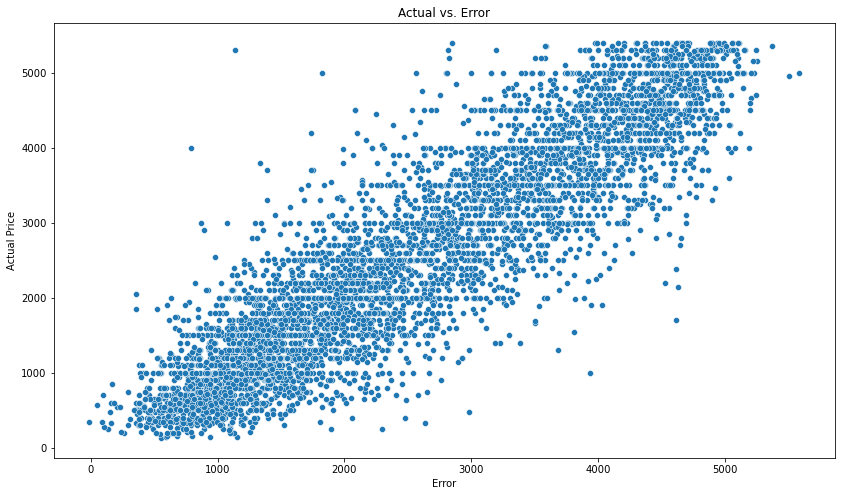

In [56]:
# Melihat persebaran Data Error
plt.figure(figsize=(14, 8))
plot = sns.scatterplot(x=y_pred, y=y_test).set(title='Actual vs. Error', 
                                               xlabel='Error', 
                                               ylabel='Actual Price');

**Feature Importances**

Untuk dapat mengetahui sebenarnya fitur apa saja yang sangat memengaruhi target (price), kita dapat mengeceknya melalui function feature_importances_.

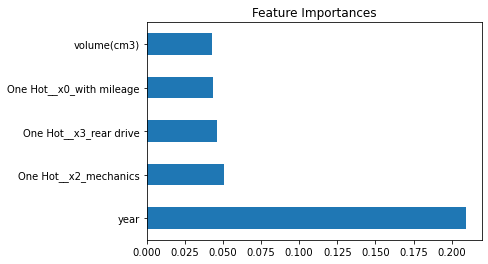

In [57]:
# Plot feature importances
feature_imp = pd.Series(XGB_Tuned._final_estimator.feature_importances_, transformer.get_feature_names()).sort_values(ascending = False).head()
feature_imp.plot(kind='barh', title='Feature Importances');

Dapat dilihat bahwa Feature Importances yang berpengaruh banyak adalah features `year` dan `volume(CM3)`

## Conclusion

Setelah dibuat model Machine Learning didapatkan beberapa jawaban untuk menjawab business question, yaitu :

    1. Machine Learning yang telah dibuat dapat digunakan untuk menggantikan proses COGS yang masih manual, untuk dapat mengurangi cost dari segi man-power serta mempersingkat waktu yang dibutuhkan untuk melakukan pengadaan barang, seperti pada Proses business tersebut

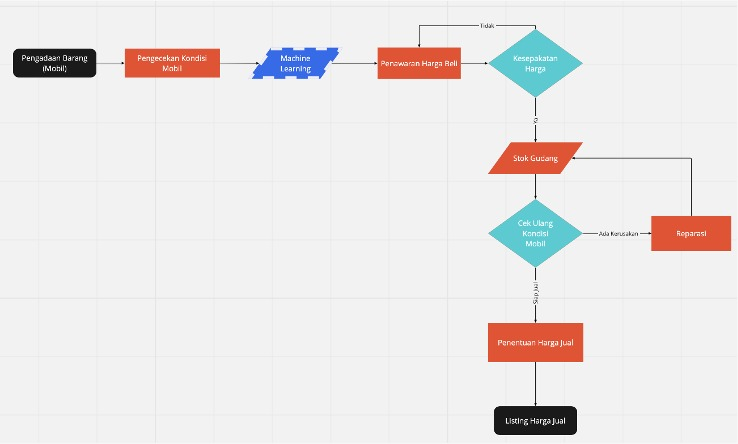

    2. Pada saat Training Data base tidak menggunakan Cross Validation Score pada saat Benchmarking, karena masalah Komputasi kami menggunakan Cross Validation ketika melakukan Tuning, Cross Validation sendiri digunakan untuk menguji kestabilan Data dan kestabilan Model
    
    3. Matrix Evaluation yang digunakan pada model adalah nilai RMSE. Jika ditinjau dari nilai RMSE yang dihasilkan oleh model setelah dilakukan hyperparameter tuning, yaitu sebesar 640,90, kita dapat menyimpulkan bahwa bila nanti model yang kita buat ini digunakan untuk memperkirakan harga mobil 2500 maka perkiraan harganya rata-rata akan meleset kurang lebih sebesar 3140,90 atau 1.859,10 dari harga yang mungkin seharusnya. Tetapi, tidak menutup kemungkinan juga prediksinya meleset lebih jauh atau hampir mendekati sempurna karena bias yang dihasilkan model masih cukup tinggi bila dilihat dari visualisasi antara harga aktual dan prediksi.
    
    4. Menentukan nilai PriceUSD dengan nilai median dilakukan karena nilai pada PriceUSD tidak terdistribusi dengan normal, sehingga diambil nilai median yang merupakan nilai Central of Tendency

## Recommendation

Rekomendasi yang disarankan adalah :

    1. Pemakaian Machine Learning dilakukan ketika kita akan memprediksi harga suatu mobil dengan harga tidak lebih dari 5.400 USD, sehingga harga yang diprediksi lebih akurat
    
    2. Menambahkan berbagai algoritma yang lebih Kompleks agar Nilai Tuning yang dihasilkan dapat lebih baik
    
    3. Mencoba berbagai kombinasi Hyper Parameter Tuning yang lain untuk mendapatkan hasil Evaluation Matrix yang lebih bagus

#### **Save Model**

In [58]:
import pickle

In [59]:
pickle.dump(RS_XGB, open('BestModel.pkl', 'wb'))

In [60]:
#### **Load model**

In [61]:
# Model = joblib.load('BestModel.pkl')

# Thankyou!!!